# step1) 데이터 준비 및 전처리

In [1]:
!pip install implicit

In [2]:
!pip list | grep implicit

implicit                      0.4.4


In [3]:
import os
import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

## 1-1. 데이터셋 구성
- `user_id` : 사용자 아이디
- `move_id` : 영화 아이디
- `rating` : 별점
- `timestap` : 별점 준 시간 

In [4]:
rating_file_path=os.getenv('HOME') + '/aiffel/enode9/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1-2. 별점을 재생횟수로
- 3점 미만은 선호하지 않는 것으로 보고 삭제
- 3점 이상인 경우 별점을 재생횟수로 생각하고 컬럼 이름 변경

In [5]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [6]:
# rating 컬럼의 이름을 count로 바꿉니다.
ratings.rename(columns={'rating':'count'}, inplace=True)

In [7]:
ratings['count']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: count, Length: 836478, dtype: int64

## 1-3. 영화 제목 메타 데이터

In [8]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/enode9/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


- 추후 분석의 용이함을 위해 개봉년도를 파생 변수로 추출하자.
- 검색을 쉽게 하기 위해 제목을 다 소문자로 바꾸고 좌우 공백을 제거했다.

In [9]:
movies['release'] = movies['title'].str[-5:-1].astype(int)
movies['title'] = movies['title'].str[:-6].str.lower().str.strip()
movies

,movie_id,title,genre,release
0,1,toy story,Animation|Children's|Comedy,1995
1,2,jumanji,Adventure|Children's|Fantasy,1995
2,3,grumpier old men,Comedy|Romance,1995
3,4,waiting to exhale,Comedy|Drama,1995
4,5,father of the bride part ii,Comedy,1995
...,...,...,...,...
3878,3948,meet the parents,Comedy,2000
3879,3949,requiem for a dream,Drama,2000
3880,3950,tigerland,Drama,2000
3881,3951,two family house,Drama,2000


# step2) 데이터 분석

## 2-1. Unique 값 분석

- rating에 있는 유니크한 사용자 수

In [10]:
ratings['user_id'].nunique()

6039

- ratings에 있는 유니크한 영화 개수

In [11]:
ratings['movie_id'].nunique()

3628

## 2-2. 사용자별 분석

- 사용자별 좋아한 영화 편수 통계

In [12]:
ratings.groupby('user_id')['movie_id'].count().describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

- 1인당 시청한 가장 많은 영화 편수는 1968개였다.
- 물리적으로 가능한 수치인가..?

- 가장 인기 있는 영화 30개 (인기순)

In [13]:
famous_movie = ratings.groupby('movie_id')['user_id'].count().sort_values(ascending=False).head(30)

In [14]:
[movie for movie, id in zip(movies['title'], movies['movie_id']) if id in famous_movie]

['toy story',
 'braveheart',
 'star wars: episode iv - a new hope',
 'pulp fiction',
 'shawshank redemption, the',
 'forrest gump',
 'fugitive, the',
 'jurassic park',
 "schindler's list",
 'terminator 2: judgment day',
 'silence of the lambs, the',
 'fargo',
 'godfather, the',
 'e.t. the extra-terrestrial',
 'star wars: episode v - the empire strikes back',
 'princess bride, the',
 'raiders of the lost ark',
 'star wars: episode vi - return of the jedi',
 'terminator, the',
 'groundhog day',
 'back to the future',
 'men in black',
 'l.a. confidential',
 'saving private ryan',
 'shakespeare in love',
 'matrix, the',
 'ghostbusters',
 'sixth sense, the',
 'american beauty',
 'being john malkovich']

<AxesSubplot:xlabel='count', ylabel='count'>

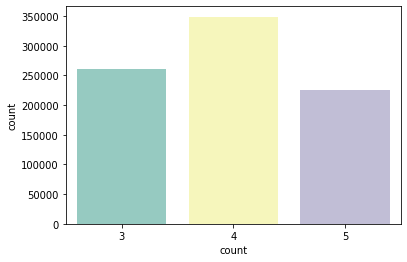

In [15]:
sns.countplot(x='count', data = ratings, palette=sns.color_palette("Set3"))
plt.show()

In [16]:
ratings.head(4)

,user_id,movie_id,count,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275


## 2-3. 모델 검증을 위해 선호하는 영화 5가지 rating에 추가
- 다 2000년 이전 영화여서 고르기가 쉽지 않은 듯 하다

In [17]:
movies[movies['release']>2000]

,movie_id,title,genre,release


In [18]:
my_favorite = ['toy story', 'lion king, the', 'pokémon the movie 2000', 'back to the future', 'aladdin' ]
my_favorite_id = [idx for title, idx in zip(movies.title, movies.movie_id) if title in my_favorite]
my_favorite_id

[1, 364, 588, 1270, 3799]

In [19]:
my_watchedlist = pd.DataFrame({'user_id':[200528]*5, 'movie_id':my_favorite_id ,'count':[4]*5})
if not ratings.isin({'user_id':[200528]})['user_id'].any():
    ratings = ratings.append(my_watchedlist, ignore_index=True)

In [20]:
ratings[ratings['user_id']==200528].any()

user_id       True
movie_id      True
count         True
timestamp    False
dtype: bool

In [21]:
ratings.tail(8)

,user_id,movie_id,count,timestamp
836475,6040,562,5,956704746.0
836476,6040,1096,4,956715648.0
836477,6040,1097,4,956715569.0
836478,200528,1,4,NaN
836479,200528,364,4,NaN
836480,200528,588,4,NaN
836481,200528,1270,4,NaN
836482,200528,3799,4,NaN


## 2-3. 영화 id 및 사용자 id 인덱싱
- 두 컬럼 다 정수지만 숫자가 이어지지 않아서 다시 인덱싱을 해준다.

In [22]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836483 entries, 0 to 836482
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    836483 non-null  int64  
 1   movie_id   836483 non-null  int64  
 2   count      836483 non-null  int64  
 3   timestamp  836478 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 25.5 MB


In [23]:
# 고유한 사용자와 영화 추출
unique_user = ratings['user_id'].unique()
unique_movie = ratings['movie_id'].unique()

# 사용자, 영화 indexing
user_to_idx = {v:k for k,v in enumerate(unique_user)}
movie_to_idx = {v:k for k,v in enumerate(unique_movie)}

In [25]:
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = ratings['movie_id'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings):
    print('movie_id column indexing OK!!')
    ratings['movie_id'] = temp_movie_data
else:
    print('movie column indexing Fail!!')

ratings

user_id column indexing OK!!
movie_id column indexing OK!!


,user_id,movie_id,count,timestamp
0,0,0,5,978300760.0
1,0,1,3,978302109.0
2,0,2,3,978301968.0
3,0,3,4,978300275.0
4,0,4,5,978824291.0
...,...,...,...,...
836478,6039,40,4,NaN
836479,6039,330,4,NaN
836480,6039,33,4,NaN
836481,6039,22,4,NaN


# step3) CSR Matrix 생성

In [26]:
ratings['user_id'].nunique()

6040

In [27]:
ratings['movie_id'].nunique()

3628

In [28]:
ratings['count'].count()

836483

In [29]:
num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()
csr_data = csr_matrix((ratings['count'],(ratings.user_id, ratings.movie_id)), shape = (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

# step3) MF 모델 구성

# step5) AltenatingLeastSquares 모델 생성 및 훈련

In [30]:
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [31]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [32]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [33]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# step6) 모델 학습 결과 분석

## 6-0. 사전에 추가했던 사용자의 특성 벡터와 선호하는 영화의 특성 벡터의 형태와 두 벡터의 내적 확인

In [34]:
new, toy_story = user_to_idx[200528], movie_to_idx[1]
new_vector, toy_story_vector = als_model.user_factors[new], als_model.item_factors[toy_story]

In [35]:
new_vector

array([-0.45789048, -0.12500013, -0.13409421, -0.28378838,  1.0139608 ,
       -0.13352135, -0.05000258, -0.01052808,  0.04298467,  0.53745013,
        0.07570723,  0.24372303, -0.4428826 ,  0.15718596,  0.41772404,
       -0.61684877,  0.41793862,  1.038861  ,  0.20694652, -0.26481712,
       -0.40598324, -0.22818066, -0.655666  , -0.06056779, -0.45605403,
       -0.5177449 ,  0.23864956,  0.08511475, -0.7960353 , -0.33195895,
        0.12815948, -0.6661421 ,  0.14988045,  0.4052909 ,  0.00642152,
       -0.302934  ,  0.64217126,  0.20289977, -0.2586199 ,  0.03260233,
       -0.47460935, -0.13161461,  0.07290754, -0.6492447 , -0.17348303,
       -0.03012614,  0.37599447, -0.44603312,  0.31979606, -0.20664537,
        0.65471685,  0.12027306, -0.3166216 ,  0.42917833,  0.55374634,
        0.6243386 ,  0.38382307, -1.0036169 , -0.41507325, -0.48752216,
        0.2762575 , -0.23224895, -0.13044523, -0.42893168,  0.18234217,
       -0.07044369, -0.1920704 , -0.6404311 , -0.01173624,  0.31

In [36]:
toy_story_vector

array([-0.00314706,  0.01192966,  0.01042574, -0.00504658,  0.03192298,
        0.01011922,  0.0017515 ,  0.00546801, -0.00614591,  0.02164052,
        0.01386214,  0.00642006, -0.01374802,  0.02375527,  0.00224539,
       -0.0137229 ,  0.02671659,  0.03119159, -0.00220316,  0.01245101,
       -0.0241963 ,  0.00450806, -0.0264008 , -0.01816485, -0.00993348,
        0.00972374,  0.02769792, -0.00126142, -0.02218457, -0.01692727,
        0.02505555, -0.0355464 ,  0.02119218,  0.00552842,  0.03326321,
       -0.00217544,  0.04994061,  0.02383985, -0.00707303,  0.02049585,
       -0.01682138, -0.02111671,  0.00640573, -0.02569073, -0.02928492,
        0.01906357,  0.0192677 , -0.00427474,  0.01033671,  0.01020434,
        0.02375352, -0.00689002,  0.00933314,  0.02451891,  0.01774687,
        0.02991289, -0.00112622, -0.01740038, -0.02167213, -0.0052175 ,
        0.01174489, -0.0329106 , -0.00878415, -0.01584945,  0.02797425,
       -0.00840544, -0.0039444 , -0.02421806,  0.01280884,  0.01

In [37]:
# 새로 추가한 사용자와 toy_story 내적
np.dot(new_vector, toy_story_vector)

0.5998609

- 0.5 이상의 결과 보여주고 있다.

## 6-1. 선호하는 5가지 영화 중 하나와 그 외 영화를 골라 예측한 선호도 파악
- def `check_prefernece(user, movie)` : 사용자가 해당 영화를 얼마나 좋아하는지 사용자 특성 벡터와 영화 특성 벡터를 내적해 수치를 보여준다.

In [38]:
def check_preference(user, movie):
    movie_id = movies[movies['title'] == movie].iloc[0,0]    
    new, fav_movie = user_to_idx[user], movie_to_idx[movie_id]
    new_vector, fav_movie_vector = als_model.user_factors[new], als_model.item_factors[fav_movie]
    print(np.dot(new_vector, fav_movie_vector))

- 확실히 시청했던 영화 벡터와의 내적이 점수가 높다.

In [39]:
# 선호하는 영화의 특성 벡터와 내적
for movie in my_favorite:
    print(f'{movie}`s score', end=' ')
    check_preference(200528, movie)

toy story`s score 0.5998609
lion king, the`s score 0.47060257
pokémon the movie 2000`s score 0.011793078
back to the future`s score 0.39999115
aladdin`s score 0.5794199


In [40]:
# 시청하지 않았던 다른 영화의 특성 벡터와 내적
check_preference(200528, 'meet the parents')
check_preference(200528, 'tigerland')

-0.043526623
-0.014419573


- 시청 기록이 없더라도 비슷한 장르의 영화는 다른 영화보다 점수가 높게 나왔다.

In [41]:
# 시청하지 않았지만 비슷한 장르의 영화
check_preference(200528, 'alice in wonderland')

0.09339066


In [42]:
movies[movies['genre'].str.contains('Animation')].sample(3)

,movie_id,title,genre,release
612,616,"aristocats, the",Animation|Children's,1970
1812,1881,quest for camelot,Adventure|Animation|Children's|Fantasy,1998
2490,2559,"king and i, the",Animation|Children's,1999


## 6-2. 좋아하는 영화와 비슷한 영화 추천
- def `get_movie_id(movie)` : 영화 제목에 해당하는 영화 아이디 반환
- def `get_genre(movie)` : 영화 제목의 장르 반환
- def `get_movie_name(movie_id)` : 영화 아이디에 해당하는 영화 제목 반환
- def `get_similar_movie(movie_name)` : 영화와 비슷한 영화 목록 반환

In [45]:
def get_movie_id(movie):
    return movies[movies['title'] == movie].iloc[0,0]

def get_genre(movie):
    return movies[movies['title']==movie].values[0,2]

def get_movie_name(movie_id):
    return movies[movies['movie_id']==movie_id].values[0,1]

idx_to_movie = {v:k for k,v in movie_to_idx.items()}

In [46]:
# 반복 확인
def get_similar_movie(movie_name: str):
    movie_id = get_movie_id(movie_name)
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [47]:
for movie_id in ratings['movie_id'].sample(5):
    movie = get_movie_name(idx_to_movie[movie_id])
    print(f'\n======<{movie}>`s similar movies======')
    for movie_id in get_similar_movie(movie):
        print(get_movie_name(movie_to_idx[movie_id]))


======<executive decision>`s similar movies======
executive decision
tales from the darkside: the movie
murder!
angus
jade
down periscope
penitentiary ii
grease 2
big green, the
sneakers

======<fish called wanda, a>`s similar movies======
fish called wanda, a
clean slate (coup de torchon)
full monty, the
sexual life of the belgians, the
arrival, the
my name is joe
lolita
candyman: farewell to the flesh
tarzan
spanking the monkey

======<terminator, the>`s similar movies======
terminator, the
delicatessen
fierce creatures
underneath, the
fugitive, the
rob roy
kissing a fool
swamp thing
mighty joe young
shakespeare in love

======<shakespeare in love>`s similar movies======
shakespeare in love
back to school
underneath, the
another man's poison
cyrano de bergerac
howard the duck
stop making sense
varsity blues
kissing a fool
misérables, les

======<miracle on 34th street>`s similar movies======
miracle on 34th street
swimming with sharks
wonderful, horrible life of leni riefenstahl, th

## 6-3. 내가 가장 좋아할 만한 영화 추천

- 이전에 추가한 좋아하는 영화 목록을 보자.

In [48]:
my_favorite

['toy story',
 'lion king, the',
 'pokémon the movie 2000',
 'back to the future',
 'aladdin']

- 해당 영화 목록을 보유하는 사용자에게 모델이 어떤 영화를 추천하는지 확인한다.

In [49]:
user = user_to_idx[200528]
# recommend에서는 user*item CSR Matrix를 받습니다.
recommended_movie = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)

- 확실히 선호하는 영화에 디즈니 영화가 많았다보니 애니메이션 관련 영화를 많이 추천해 주었다.

In [50]:
# 추천 영화 순위 및 점수
[(get_movie_name(idx_to_movie[movie_id]), score) for movie_id, score in recommended_movie]

[('toy story 2', 0.46149746),
 ('beauty and the beast', 0.45687643),
 ("bug's life, a", 0.35265052),
 ('babe', 0.29136252),
 ('little mermaid, the', 0.25241354),
 ('forrest gump', 0.2299691),
 ('tarzan', 0.217454),
 ('hercules', 0.20888785),
 ('mulan', 0.20592381),
 ('e.t. the extra-terrestrial', 0.19256899),
 ('groundhog day', 0.1892686),
 ('snow white and the seven dwarfs', 0.17693682),
 ('hunchback of notre dame, the', 0.17685229),
 ('star wars: episode v - the empire strikes back', 0.16675389),
 ('2001: a space odyssey', 0.16665715),
 ('fantasia', 0.16368756),
 ('shakespeare in love', 0.15962169),
 ('mask, the', 0.15246198),
 ('apollo 13', 0.15023418),
 ('mary poppins', 0.14941864)]

## 6-4. 추천한 영화에 영향을 미친 영화순위와 장르
- def `recommend(user_id)` : 해당 사용자의 시청 목록을 기반으로 추천할 만한 영화 및 점수 목록 반환
- def `explainer(user_id, recommended_movie_name)` : 사용자가 시청한 영화가 추천한 영화에 미친 영향 파악

In [51]:
# 다른 사용자의 추천 영화 리스트를 알기 위한 함수
def recommend(user_id):
    user = user_to_idx[user_id]
    recommended_movie = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
    return [(get_movie_name(idx_to_movie[movie_id]), score) for movie_id, score in recommended_movie]

In [52]:
def explainer(user_id,recommended_movie_name):
    print('원 장르 : ',get_genre(recommended_movie_name))
    user = user_to_idx[user_id]
    movie_id = get_movie_id(recommended_movie_name)
    explain = als_model.explain(user, csr_data, itemid=movie_id)
    return pd.DataFrame([(get_movie_name(idx_to_movie[i[0]]), i[1],get_genre(get_movie_name(idx_to_movie[i[0]]))) for i in explain[1]],columns=['title','score','genre'])

In [53]:
explainer(200528,"e.t. the extra-terrestrial")

원 장르 :  Children's|Drama|Fantasy|Sci-Fi


,title,score,genre
0,back to the future,0.070740,Comedy|Sci-Fi
1,aladdin,0.031779,Animation|Children's|Comedy|Musical
2,"lion king, the",0.013682,Animation|Children's|Musical
3,toy story,-0.006107,Animation|Children's|Comedy
4,pokémon the movie 2000,-0.007250,Animation|Children's


In [54]:
explainer(200528,'forrest gump')

원 장르 :  Comedy|Romance|War


,title,score,genre
0,aladdin,0.007582,Animation|Children's|Comedy|Musical
1,"lion king, the",0.006662,Animation|Children's|Musical
2,pokémon the movie 2000,0.000839,Animation|Children's
3,back to the future,-0.000770,Comedy|Sci-Fi
4,toy story,-0.032589,Animation|Children's|Comedy


- 추천 점수가 낮았던 영화는 그에 걸맞게 장르에서도 많이는 겹치지 않았다.
- `star wars` 추천에서 특이한 점은 그래도 장르가 겹쳤던 `back to the future`가 큰 영향을 미치지 않았다는 점이었다.

In [55]:
explainer(200528,'star wars: episode v - the empire strikes back')

원 장르 :  Action|Adventure|Drama|Sci-Fi|War


,title,score,genre
0,toy story,0.028430,Animation|Children's|Comedy
1,back to the future,0.002073,Comedy|Sci-Fi
2,pokémon the movie 2000,0.000638,Animation|Children's
3,"lion king, the",-0.013795,Animation|Children's|Musical
4,aladdin,-0.031501,Animation|Children's|Comedy|Musical


- 다른 사용자의 추천 영화를 보자.

In [56]:
ratings['user_id'].unique()[1:20:4]

array([ 1,  5,  9, 13, 17])

- 1번 사용자는 애니메이션을 많이 시청한 것으로 보인다.

In [57]:
recommend(1)

[('lion king, the', 1.0387063),
 ('shawshank redemption, the', 0.8288442),
 ('little mermaid, the', 0.8069404),
 ('babe', 0.78645074),
 ('jungle book, the', 0.75622165),
 ('amadeus', 0.7494767),
 ('fantasia', 0.74385124),
 ('sleeping beauty', 0.7383149),
 ('pinocchio', 0.6967769),
 ('peter pan', 0.64731944),
 ('raiders of the lost ark', 0.63259935),
 ('good will hunting', 0.6276747),
 ('star wars: episode v - the empire strikes back', 0.6123146),
 ('silence of the lambs, the', 0.6035732),
 ('ghostbusters', 0.58210945),
 ('alice in wonderland', 0.57005847),
 ('101 dalmatians', 0.5677511),
 ('lady and the tramp', 0.5664714),
 ('wrong trousers, the', 0.56486976),
 ('american beauty', 0.55412745)]

In [58]:
explainer(1, 'lion king, the')

원 장르 :  Animation|Children's|Musical


,title,score,genre
0,saving private ryan,0.036562,Action|Drama|War
1,toy story 2,0.024389,Animation|Children's|Comedy
2,one flew over the cuckoo's nest,0.021088,Drama
3,"secret garden, the",0.019568,Children's|Drama
4,meet joe black,0.018951,Romance
5,back to the future,0.016251,Comedy|Sci-Fi
6,big,0.016031,Comedy|Fantasy
7,pocahontas,0.015086,Animation|Children's|Musical|Romance
8,bambi,0.013638,Animation|Children's
9,driving miss daisy,0.012957,Drama


In [59]:
recommend(48)

[('star trek: first contact', 1.0955336),
 ('dr. no', 1.0917943),
 ('sneakers', 1.0704753),
 ('outbreak', 1.0541794),
 ('lady and the tramp', 1.0099185),
 ('from russia with love', 0.9499478),
 ('rush hour', 0.9493133),
 ('nightmare before christmas, the', 0.9358027),
 ('ghost and the darkness, the', 0.93150127),
 ('what about bob?', 0.9088996),
 ('austin powers: international man of mystery', 0.89919704),
 ('birdcage, the', 0.8904398),
 ('die hard: with a vengeance', 0.8782613),
 ('west side story', 0.8751185),
 ('honey, i shrunk the kids', 0.8718513),
 ('say anything...', 0.85871),
 ('breakdown', 0.84899837),
 ('dr. strangelove or: how i learned to stop worrying and love the bomb',
  0.84175265),
 ('rock, the', 0.83849305),
 ('fantasia 2000', 0.83838785)]

In [60]:
explainer(48, 'sneakers')

원 장르 :  Crime|Drama|Sci-Fi


,title,score,genre
0,breakfast at tiffany's,0.030017,Drama|Romance
1,shampoo,0.026383,Comedy|Romance
2,october sky,0.017764,Drama
3,help!,0.017426,Comedy|Musical
4,titanic,0.016558,Drama|Romance
5,"odd couple, the",0.016481,Comedy
6,american beauty,0.015457,Comedy|Drama
7,superman,0.014821,Action|Adventure|Sci-Fi
8,"jerk, the",0.013788,Comedy
9,"wild bunch, the",0.013706,Western


- 실제 영향을 미친 스코어를 볼 때는 추천받은 영화의 장르와 이전에 시청한 장르가 그렇게 큰 영향을 미치지는 않는다.
- 시청한 영화의 개수가 많아서 그런가?
- 48번 사용자가 시청한 영화 개수는 101개였다.

In [61]:
ratings[ratings['user_id']==48].nunique()

user_id        1
movie_id     101
count          3
timestamp     46
dtype: int64

# 회고

- 다양한 OTT 서비스를 사용하면서 추천시스템에 불만을 느낀 적도 있었는데 직접 구현해보니 사용자가 만족할만한 성능을 내는 것은 어려운 일임을 다시 깨달았다.
- 영화의 장르, 개봉년도, 리뷰를 남긴 시간대 등의 다양한 메타 정보를 적절하게 활용할 수 있는 방법을 찾아봐야겠다.